#### Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, random_split, TensorDataset
from torchvision.transforms import ToTensor
warnings.filterwarnings('ignore')





import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
warnings.filterwarnings('ignore')

#### One hot encoder

In [ ]:
import numpy as np

def one_hot_encode(matrix):


    unique_values = np.unique(matrix)
    num_classes = len(unique_values)
    value_to_index = {val: idx for idx, val in enumerate(unique_values)}
    one_hot_encoded = np.zeros((matrix.size, num_classes))


    for i, val in enumerate(matrix):
        one_hot_encoded[i, value_to_index[val]] = 1

    return one_hot_encoded


#### Resizing Images (Flattening)

In [ ]:
def resize_and_flatten(data, new_size=(28, 28)):

    resized = np.array([np.resize(image, new_size).flatten() for image in data])
    return resized

#### Dataset loading and preprocessing

In [ ]:
train_dataset = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_dataset = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)


validation_size = 10000
training_size = len(train_dataset) - validation_size

train_dataset, val_dataset = random_split(train_dataset, [training_size, validation_size])

train_loader = DataLoader(train_dataset, batch_size=training_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=validation_size, shuffle=False)

train_data = next(iter(train_loader))
X_train = train_data[0].numpy()
y_train = one_hot_encode(train_data[1].numpy())

val_data = next(iter(val_loader))
X_val = val_data[0].numpy()
y_val = one_hot_encode(val_data[1].numpy())

test_loader = DataLoader(test_dataset, batch_size= 10000, shuffle=True)
test_data = next(iter(test_loader))

X_test = test_data[0].numpy()
y_test = one_hot_encode(test_data[1].numpy())

#Flattenning the datasets
X_train = resize_and_flatten(X_train)
X_val = resize_and_flatten(X_val)
X_test = resize_and_flatten(X_test)




#### Initialization of parameters

In [ ]:

def glorot_init(inputs, neurons , outputs):
    parameters = {}
    Ni , No = inputs, neurons[0]
    M = np.sqrt(6/(Ni+No))
    parameters["W1"] = np.random.uniform(low = -M, high = M, size = (neurons[0], inputs))
    parameters["b1"] = np.zeros(neurons[0])

    for i in range(1, len(neurons)):
        Ni , No = neurons[i], neurons[i-1]
        M = np.sqrt(6/(Ni+No))

        parameters[f"W{i+1}"] = np.random.uniform(low = -M, high = M, size = (neurons[i], neurons[i - 1]))
        parameters[f"b{i+1}"] = np.zeros(neurons[i])

    parameters[f"W{len(neurons) + 1}"] = np.random.uniform(low = -M, high = M, size = (outputs, neurons[- 1]))
    parameters[f"b{len(neurons) + 1}"] = np.zeros(outputs)
    return parameters

#### Functions used in Feedforward and backprop

In [ ]:
def sigmoid(x):
    return expit(x)
def relu(x):
    return np.maximum(0, x)

from scipy.special import expit



def drelu(x):
    return np.where(x > 0, 1, 0)

def dtanh(x):
    return 1 - (np.tanh(x) ** 2)
def tanh(x):
    return np.tanh(x)
def gradient_w(x,w,b,y):
    f_x = w.T  @ x
    return sigmoid(w.T @ x) * (1-sigmoid(w.T @ x)) * (f_x - y) * x


def dsigmoid(a):
    return sigmoid(a) * (1-sigmoid(a))

def gradient_b(x,w,b,y):
    f_x = w.T  @ x
    return sigmoid(w.T @ x) * (1-sigmoid(w.T @ x)) * (f_x - y)

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def cross_entropy(y_p, y_t):
    return -np.sum(y_t * np.log(y_p))

def average_every_200_elements(data):
    averages = []

    for i in range(0, len(data), 200):
        chunk = data[i:i + 200]
        chunk_sum = sum(chunk)
        chunk_avg = chunk_sum / len(chunk)
        averages.append(chunk_avg)
    return averages

#### Forward propogation

In [ ]:
def forward_prop(x, parameter, h, g_act):


    activation_output = {}

    activation_output[f'a{1}'] =  parameter[f'W{1}'] @ x + parameter[f'b{1}']

    activation_output[f'h{1}'] = g_act(activation_output[f'a{1}'])

    activation_output['h0'] = x

    for i in range(2,h-1):



        activation_output[f'a{i}'] =  parameter[f'W{i}'] @  activation_output[f'h{i-1}'] + parameter[f'b{i}']

        activation_output[f'h{i}'] = g_act(activation_output[f'a{i}'])


    activation_output[f'a{h-1}'] =  parameter[f'W{h-1}'] @  activation_output[f'h{h-2}'] + parameter[f'b{h-1}']
    activation_output[f'h{h-1}'] = softmax(activation_output[f'a{h-1}'])

    activation_output['a1']  =  activation_output['a1'].T
    activation_output['h1'] =  activation_output['h1'].T
    return activation_output


#### Backpropogation

In [ ]:
def backprop(activation_output, parameters, y, k, cl, d_act):
    # d_act = f"d{g_act}"
    y_p = activation_output[f'h{k}']
    dl_aL = y_p - y
    gradients = {}
    gradients[f"dW{k}"] = np.outer(dl_aL,  activation_output[f"h{k-1}"] )
    gradients[f"db{k}"] = dl_aL.copy()
    dl_hl = dl_aL@ parameters[f"W{k}"]
    dl_aL = (dl_hl) * d_act(activation_output[f"a{k-1}"])

    for i in range(k-1, 1, -1):



        gradients[f'dW{i}'] = np.outer(dl_aL,  activation_output[f'h{i-1}'] )

        gradients[f'db{i}'] = dl_aL.copy()


        dl_hl = dl_hl =  dl_aL@ parameters[f"W{i}"]
        dl_aL = (dl_hl) * d_act(activation_output[f'a{i-1}'])

    gradients['dW1'] = np.outer(dl_aL, activation_output['h0'])
    gradients['db1'] = dl_aL.copy()

    return gradients


#### Gradient Descent

In [ ]:
def gradient_descent(parameters, losses, eta):
    new_parameters = parameters.copy()

    for i in range(len(parameters) // 2):
        new_parameters[f"W{i + 1}"] = parameters[f"W{i + 1}"] - eta * losses[f"dW{i + 1}"]
        new_parameters[f"b{i + 1}"] = parameters[f"b{i + 1}"] - eta * losses[f"db{i + 1}"]

    return new_parameters

#### Batch Gradient Descent Training

In [ ]:
import numpy as np

def train_batch2(X_train, y_one_hot_train, parameters, total_layers, epochs, eta, batch_size, g_act, d_act):
    train_losses = []
    iteration_losses = []
    epoch_losses = []
    batch_losses = []

    for epoch in range(epochs):

        permutation = np.random.permutation(X_train.shape[0])
        inputs_shuffled = X_train[permutation]
        outputs_shuffled = y_one_hot_train[permutation]

        print(f"Epoch {epoch + 1}/{epochs}")

        total_loss = 0
        num_batches = int(np.ceil(X_train.shape[0] / batch_size))

        for i in range(0, X_train.shape[0], batch_size):

            end = min(i + batch_size, X_train.shape[0])
            batch_inputs = inputs_shuffled[i:end]
            batch_outputs = outputs_shuffled[i:end]


            total_gradient_loss = {f'd{key}': np.zeros_like(value) for key, value in parameters.items()}
            batch_loss = 0


            for x, y in zip(batch_inputs, batch_outputs):
                activation_output = forward_prop(x, parameters, total_layers, g_act)
                gradients = backprop(activation_output, parameters, y, total_layers - 1, cl=y_one_hot_train.shape[1], d_act=d_act)
                batch_loss += cross_entropy(activation_output[f'h{total_layers - 1}'], y)


                for key in total_gradient_loss:
                    total_gradient_loss[key] += gradients[key]


            batch_size_actual = len(batch_inputs)
            for key in total_gradient_loss:
                total_gradient_loss[key] /= batch_size_actual


            parameters = gradient_descent(parameters, total_gradient_loss, eta)


            batch_loss /= batch_size_actual
            total_loss += batch_loss
            batch_losses.append(batch_loss)


        epoch_loss = total_loss / num_batches
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch + 1}/{epochs}, Training Loss: {epoch_loss:.4f}')


    return parameters, train_losses, batch_losses


### Parameters

In [ ]:
parameters = glorot_init(784, [500,250,100] , 10)
total_layers = 5
epochs = 15
eta = 0.01
batch_size = 64

### Sigmoid Activation

In [ ]:
g_act = sigmoid
d_act = dsigmoid
new_params_sig, train_losses_sig, iteration_losses_sig= train_batch2(X_train, y_train, parameters, total_layers, epochs, eta, batch_size, g_act, d_act)

Epoch 1/15
Epoch 1/15, Training Loss: 2.3023
Epoch 2/15
Epoch 2/15, Training Loss: 2.2958
Epoch 3/15
Epoch 3/15, Training Loss: 2.2908
Epoch 4/15
Epoch 4/15, Training Loss: 2.2849
Epoch 5/15
Epoch 5/15, Training Loss: 2.2764
Epoch 6/15
Epoch 6/15, Training Loss: 2.2641
Epoch 7/15
Epoch 7/15, Training Loss: 2.2432
Epoch 8/15
Epoch 8/15, Training Loss: 2.2037
Epoch 9/15
Epoch 9/15, Training Loss: 2.1257
Epoch 10/15
Epoch 10/15, Training Loss: 1.9913
Epoch 11/15
Epoch 11/15, Training Loss: 1.8401
Epoch 12/15
Epoch 12/15, Training Loss: 1.7051
Epoch 13/15
Epoch 13/15, Training Loss: 1.5593
Epoch 14/15
Epoch 14/15, Training Loss: 1.3855
Epoch 15/15
Epoch 15/15, Training Loss: 1.2161


Plot of training losses with sigmoid activation

Text(0, 0.5, 'Training Loss')

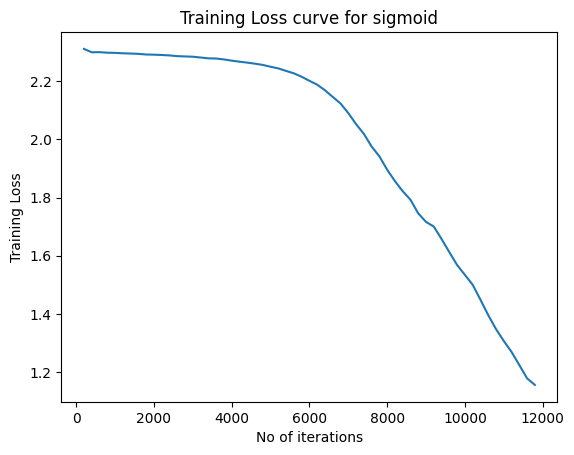

In [ ]:

sigmoid_200_iter = average_every_200_elements(iteration_losses_sig)
x = [(i+1)*200 for i in range(len(sigmoid_200_iter ))]
plt.plot(x, sigmoid_200_iter )
plt.title("Training Loss curve for sigmoid")
plt.xlabel("No of iterations")
plt.ylabel("Training Loss")


Classification report of training loss with sigmoid activation

In [ ]:

y_pred_sig = []
for x,y in zip(X_train, y_train):

    y_pred_sig.append(np.argmax(forward_prop(x, new_params_sig, 5, sigmoid)['h4']))

y_train_nos = []
for y in y_train:
    y_train_nos.append(np.argmax(y))

from sklearn.metrics import classification_report

print(classification_report(y_train_nos, y_pred_sig))

              precision    recall  f1-score   support

           0       0.77      0.91      0.84      4884
           1       0.75      0.97      0.85      5672
           2       0.63      0.54      0.58      4948
           3       0.63      0.73      0.68      5106
           4       0.59      0.63      0.61      4850
           5       0.67      0.46      0.54      4513
           6       0.67      0.75      0.71      4935
           7       0.64      0.77      0.70      5202
           8       0.64      0.41      0.50      4891
           9       0.53      0.38      0.44      4999

    accuracy                           0.66     50000
   macro avg       0.65      0.66      0.64     50000
weighted avg       0.65      0.66      0.65     50000



Classification report of test loss with sigmoid activation

In [ ]:
y_pred_test_sig = []
for x,y in zip(X_test, y_test):

    y_pred_test_sig.append(np.argmax(forward_prop(x, new_params_sig, 5, sigmoid)['h4']))

y_test_nos = []

for y in y_test:
    y_test_nos.append(np.argmax(y))

print(classification_report(y_test_nos, y_pred_test_sig))

              precision    recall  f1-score   support

           0       0.73      0.92      0.82       980
           1       0.79      0.98      0.88      1135
           2       0.67      0.54      0.60      1032
           3       0.61      0.76      0.68      1010
           4       0.58      0.60      0.59       982
           5       0.67      0.45      0.54       892
           6       0.69      0.75      0.72       958
           7       0.62      0.77      0.69      1028
           8       0.66      0.41      0.50       974
           9       0.51      0.38      0.43      1009

    accuracy                           0.66     10000
   macro avg       0.65      0.66      0.64     10000
weighted avg       0.65      0.66      0.65     10000



### Tanh Activation

In [ ]:
g_act = tanh
d_act = dtanh
new_params_tanh, train_losses_tanh, iteration_losses_tanh  = train_batch2(X_train, y_train, parameters, total_layers, epochs, eta, batch_size, g_act, d_act)

Epoch 1/15
Epoch 1/15, Training Loss: 0.8047
Epoch 2/15
Epoch 2/15, Training Loss: 0.3826
Epoch 3/15
Epoch 3/15, Training Loss: 0.3202
Epoch 4/15
Epoch 4/15, Training Loss: 0.2893
Epoch 5/15
Epoch 5/15, Training Loss: 0.2675
Epoch 6/15
Epoch 6/15, Training Loss: 0.2498
Epoch 7/15
Epoch 7/15, Training Loss: 0.2351
Epoch 8/15
Epoch 8/15, Training Loss: 0.2220
Epoch 9/15
Epoch 9/15, Training Loss: 0.2104
Epoch 10/15
Epoch 10/15, Training Loss: 0.1995
Epoch 11/15
Epoch 11/15, Training Loss: 0.1893
Epoch 12/15
Epoch 12/15, Training Loss: 0.1801
Epoch 13/15
Epoch 13/15, Training Loss: 0.1722
Epoch 14/15
Epoch 14/15, Training Loss: 0.1640
Epoch 15/15
Epoch 15/15, Training Loss: 0.1572


Plotting train losses for tanh Activation

Text(0, 0.5, 'Training Loss')

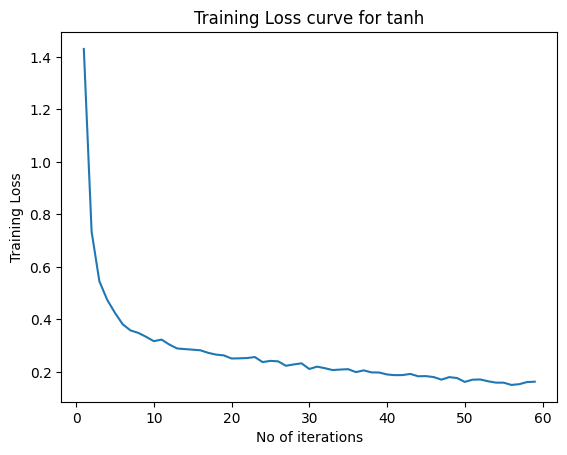

In [ ]:
tanh_200_iter = average_every_200_elements(iteration_losses_tanh)
x = [i+1 for i in range(len(tanh_200_iter))]
plt.plot(x, tanh_200_iter)
plt.title("Training Loss curve for tanh")
plt.xlabel("No of iterations")
plt.ylabel("Training Loss")

Classification report of train loss with tanh activation

In [ ]:
y_pred_tanh = []
for x,y in zip(X_train, y_train):

    y_pred_tanh.append(np.argmax(forward_prop(x, new_params_tanh, 5, tanh)['h4']))

y_train_nos = []
for y in y_train:
    y_train_nos.append(np.argmax(y))

from sklearn.metrics import classification_report

print(classification_report(y_train_nos, y_pred_tanh))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      4884
           1       0.97      0.98      0.98      5672
           2       0.96      0.95      0.95      4948
           3       0.94      0.96      0.95      5106
           4       0.95      0.95      0.95      4850
           5       0.95      0.94      0.95      4513
           6       0.97      0.97      0.97      4935
           7       0.97      0.96      0.96      5202
           8       0.94      0.94      0.94      4891
           9       0.95      0.94      0.94      4999

    accuracy                           0.96     50000
   macro avg       0.96      0.96      0.96     50000
weighted avg       0.96      0.96      0.96     50000



Classification report of test loss with tanh activation

In [ ]:
y_pred_test_tanh = []
for x,y in zip(X_test, y_test):

    y_pred_test_tanh.append(np.argmax(forward_prop(x, new_params_tanh, 5, tanh)['h4']))

y_test_nos = []

for y in y_test:
    y_test_nos.append(np.argmax(y))

print(classification_report(y_test_nos, y_pred_test_tanh))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.98      0.99      0.98      1135
           2       0.96      0.94      0.95      1032
           3       0.93      0.96      0.95      1010
           4       0.96      0.95      0.95       982
           5       0.95      0.93      0.94       892
           6       0.96      0.96      0.96       958
           7       0.96      0.94      0.95      1028
           8       0.94      0.94      0.94       974
           9       0.95      0.93      0.94      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



### RELU Activation

In [ ]:
g_act = relu
d_act = drelu
new_params_relu, train_losses_relu, iteration_losses_relu= train_batch2(X_train, y_train, parameters, total_layers, epochs, eta, batch_size, g_act, d_act)

Epoch 1/15
Epoch 1/15, Training Loss: 1.0930
Epoch 2/15
Epoch 2/15, Training Loss: 0.3739
Epoch 3/15
Epoch 3/15, Training Loss: 0.3011
Epoch 4/15
Epoch 4/15, Training Loss: 0.2609
Epoch 5/15
Epoch 5/15, Training Loss: 0.2320
Epoch 6/15
Epoch 6/15, Training Loss: 0.2082
Epoch 7/15
Epoch 7/15, Training Loss: 0.1885
Epoch 8/15
Epoch 8/15, Training Loss: 0.1718
Epoch 9/15
Epoch 9/15, Training Loss: 0.1578
Epoch 10/15
Epoch 10/15, Training Loss: 0.1455
Epoch 11/15
Epoch 11/15, Training Loss: 0.1339
Epoch 12/15
Epoch 12/15, Training Loss: 0.1244
Epoch 13/15
Epoch 13/15, Training Loss: 0.1160
Epoch 14/15
Epoch 14/15, Training Loss: 0.1080
Epoch 15/15
Epoch 15/15, Training Loss: 0.1011


Plotting train losses for RELU

Text(0, 0.5, 'Training Loss')

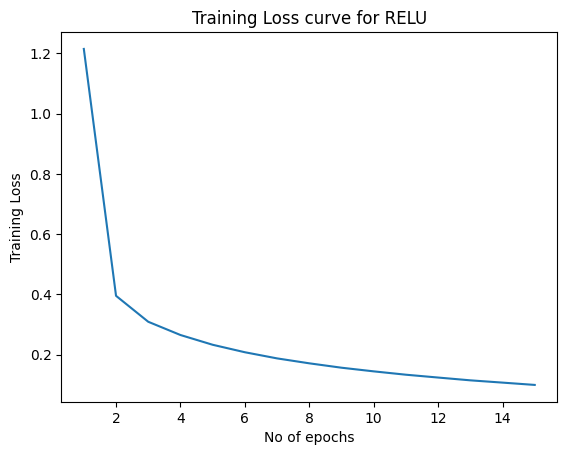

In [ ]:
tanh_200_iter = average_every_200_elements(iteration_losses_relu)
x = [i+1 for i in range(len(tanh_200_iter))]
plt.plot(x, tanh_200_iter)
plt.title("Training Loss curve for RELU")
plt.xlabel("No of iteration")
plt.ylabel("Training Loss")

Classification report of train loss with RELU

In [ ]:
y_pred_relu = []
for x,y in zip(X_train, y_train):

    y_pred_relu.append(np.argmax(forward_prop(x, new_params_relu, 5, relu)['h4']))

y_train_nos = []

for y in y_train:
    y_train_nos.append(np.argmax(y))

print(classification_report(y_train_nos, y_pred_relu))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      4940
           1       0.98      0.99      0.98      5622
           2       0.99      0.95      0.97      4916
           3       0.96      0.97      0.97      5102
           4       0.97      0.96      0.97      4867
           5       0.97      0.97      0.97      4521
           6       0.98      0.98      0.98      4984
           7       0.99      0.88      0.93      5216
           8       0.96      0.95      0.96      4865
           9       0.84      0.99      0.91      4967

    accuracy                           0.96     50000
   macro avg       0.96      0.96      0.96     50000
weighted avg       0.96      0.96      0.96     50000



Classification report of test loss with RELU

In [ ]:
y_pred_test_relu = []
for x,y in zip(X_test, y_test):

    y_pred_test_relu.append(np.argmax(forward_prop(x, new_params_relu, 5, relu)['h4']))

y_test_nos = []

for y in y_test:
    y_test_nos.append(np.argmax(y))

print(classification_report(y_test_nos, y_pred_test_relu))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.98      0.99      0.98      1135
           2       0.98      0.95      0.96      1032
           3       0.94      0.97      0.95      1010
           4       0.96      0.95      0.96       982
           5       0.96      0.96      0.96       892
           6       0.97      0.96      0.97       958
           7       0.99      0.87      0.93      1028
           8       0.96      0.95      0.96       974
           9       0.85      0.97      0.91      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



# Pytorch Implementation with adam

### Feedforward

In [30]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hl1, hl2, hl3, output_size, activation=nn.Sigmoid(), output_fn=nn.Softmax()):
        super(FeedForwardNN, self).__init__()
        self.layer1 = nn.Linear(input_size, hl1)
        self.layer2 = nn.Linear(hl1, hl2)
        self.layer3 = nn.Linear(hl2, hl3)
        self.output_layer = nn.Linear(hl3, output_size)
        self.activation = activation
        self.output_fn = output_fn

    def forward(self, x):
        h1 = self.activation(self.layer1(x))
        h2 = self.activation(self.layer2(h1))
        h3 = self.activation(self.layer3(h2))
        output = self.output_fn(self.output_layer(h3))
        return output

### Train Data Loading

In [31]:

# Load MNIST dataset
train_dataset = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_dataset = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)


### Model Setup: FeedForwardNN, Loss Function, and Optimizer

In [32]:
torch_model = FeedForwardNN(784, 500, 250, 100, 10, activation=torch.sigmoid).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(torch_model.parameters(), lr=0.01)
torch_model

FeedForwardNN(
  (layer1): Linear(in_features=784, out_features=500, bias=True)
  (layer2): Linear(in_features=500, out_features=250, bias=True)
  (layer3): Linear(in_features=250, out_features=100, bias=True)
  (output_layer): Linear(in_features=100, out_features=10, bias=True)
  (output_fn): Softmax(dim=None)
)

### Train Function

In [33]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=15, device='cpu'):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        val_loss = 0.0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x.view(-1, 784))
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            model.eval()
            with torch.no_grad():
                outputs = model(batch_x.view(-1, 784))
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    return train_losses, val_losses




### Data Preperation

In [34]:
import torch
from torch.utils.data import DataLoader, random_split


batch_size = 64



train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])


train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

### Training

In [35]:
train_loss, val_loss = train(torch_model, train_loader, val_loader, criterion, optimizer, num_epochs=15, device=device)

Epoch 1/15, Train Loss: 1.6758, Val Loss: 1.5496
Epoch 2/15, Train Loss: 1.5366, Val Loss: 1.5314
Epoch 3/15, Train Loss: 1.5264, Val Loss: 1.5312
Epoch 4/15, Train Loss: 1.5219, Val Loss: 1.5241
Epoch 5/15, Train Loss: 1.5170, Val Loss: 1.5278
Epoch 6/15, Train Loss: 1.5161, Val Loss: 1.5137
Epoch 7/15, Train Loss: 1.5159, Val Loss: 1.5257
Epoch 8/15, Train Loss: 1.5104, Val Loss: 1.5121
Epoch 9/15, Train Loss: 1.5113, Val Loss: 1.5113
Epoch 10/15, Train Loss: 1.5102, Val Loss: 1.5151
Epoch 11/15, Train Loss: 1.5085, Val Loss: 1.5141
Epoch 12/15, Train Loss: 1.5109, Val Loss: 1.5216
Epoch 13/15, Train Loss: 1.5099, Val Loss: 1.5179
Epoch 14/15, Train Loss: 1.5085, Val Loss: 1.5127
Epoch 15/15, Train Loss: 1.5078, Val Loss: 1.5079


### Plotting

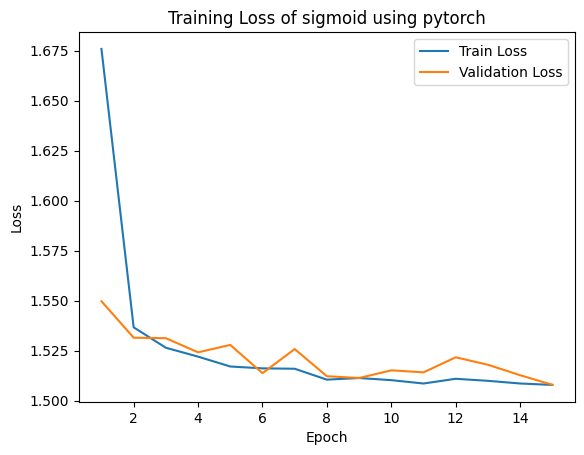

In [36]:
x_t = [i+1 for i  in range(len(train_loss))]
x_v = [i+1 for i  in range(len(val_loss))]
plt.plot(x_t, train_loss, label='Train Loss')
plt.plot(x_v, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Training Loss of sigmoid using pytorch")
plt.legend()

In [37]:
def evaluate(model, data_loader, criterion, device='cpu'):
    model.eval()
    y_pred = []
    true_y = []
    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x.view(-1, 784))
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.cpu().numpy())
            true_y.extend(y.cpu().numpy())
    return y_pred, true_y





### Train Data Classification Report

In [38]:
from sklearn.metrics import classification_report
y_pred_train, y_train = evaluate(torch_model, train_loader, criterion, device=device)
print(classification_report(y_pred_train, y_train))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4777
           1       0.98      0.98      0.98      5455
           2       0.95      0.97      0.96      4700
           3       0.95      0.94      0.95      4939
           4       0.95      0.96      0.96      4624
           5       0.96      0.95      0.96      4419
           6       0.98      0.96      0.97      4873
           7       0.96      0.97      0.97      4911
           8       0.94      0.95      0.94      4615
           9       0.94      0.94      0.94      4687

    accuracy                           0.96     48000
   macro avg       0.96      0.96      0.96     48000
weighted avg       0.96      0.96      0.96     48000



### Test Data Classification Report

In [39]:
y_pred_test, y_test = evaluate(torch_model, test_loader, criterion, device=device)
print(classification_report(y_pred_test, y_test))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1003
           1       0.98      0.98      0.98      1138
           2       0.95      0.97      0.96      1010
           3       0.96      0.94      0.95      1033
           4       0.94      0.96      0.95       958
           5       0.94      0.94      0.94       888
           6       0.97      0.94      0.95       993
           7       0.95      0.96      0.95      1009
           8       0.92      0.95      0.93       952
           9       0.94      0.93      0.93      1016

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



## L2 Regularization

In [57]:
alpha = 0.01
optimizer_l2 = optim.Adam(torch_model.parameters(), lr=0.01, weight_decay=1e-3)


Epoch 1/15, Train Loss: 1.6585, Val Loss: 1.6529
Epoch 2/15, Train Loss: 1.6603, Val Loss: 1.6698
Epoch 3/15, Train Loss: 1.6597, Val Loss: 1.7017
Epoch 4/15, Train Loss: 1.6589, Val Loss: 1.6453
Epoch 5/15, Train Loss: 1.6593, Val Loss: 1.6730
Epoch 6/15, Train Loss: 1.6609, Val Loss: 1.6364
Epoch 7/15, Train Loss: 1.6601, Val Loss: 1.6846
Epoch 8/15, Train Loss: 1.6579, Val Loss: 1.6665
Epoch 9/15, Train Loss: 1.6582, Val Loss: 1.6677
Epoch 10/15, Train Loss: 1.6601, Val Loss: 1.6705
Epoch 11/15, Train Loss: 1.6588, Val Loss: 1.6515
Epoch 12/15, Train Loss: 1.6590, Val Loss: 1.6419
Epoch 13/15, Train Loss: 1.6582, Val Loss: 1.7043
Epoch 14/15, Train Loss: 1.6584, Val Loss: 1.6694
Epoch 15/15, Train Loss: 1.6578, Val Loss: 1.6401


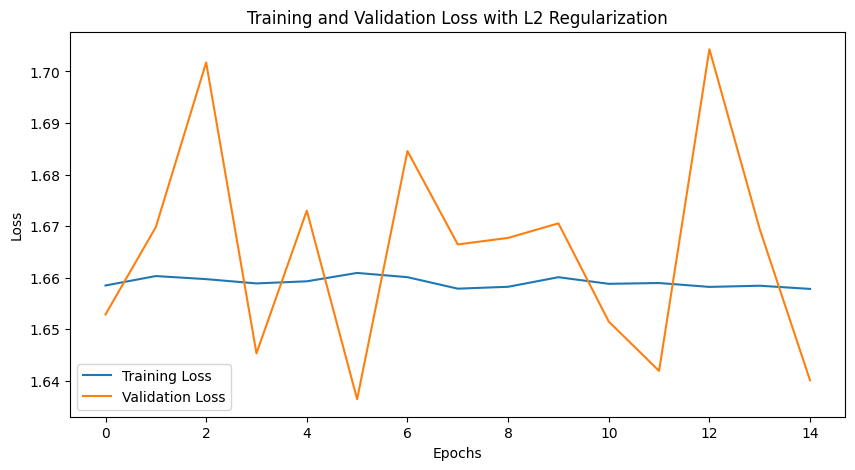

In [59]:
train_loss, val_loss = train(torch_model, train_loader, val_loader, criterion, optimizer_l2, num_epochs=15, device=device)


plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss with L2 Regularization')
plt.legend()
plt.show()

In [60]:
torch_model_l2 = FeedForwardNN(784, 500, 250, 100, 10, activation=torch.sigmoid).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(torch_model_l2.parameters(), lr=0.01, weight_decay = alpha)
torch_model

FeedForwardNN(
  (layer1): Linear(in_features=784, out_features=500, bias=True)
  (layer2): Linear(in_features=500, out_features=250, bias=True)
  (layer3): Linear(in_features=250, out_features=100, bias=True)
  (output_layer): Linear(in_features=100, out_features=10, bias=True)
  (output_fn): Softmax(dim=None)
)

### Classification Report for train data using L2

In [61]:
y_pred_train, y_train = evaluate(torch_model_l2, train_loader, criterion, device=device)
print(classification_report(y_pred_train, y_train))

              precision    recall  f1-score   support

           0       1.00      0.10      0.18     48000
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

    accuracy                           0.10     48000
   macro avg       0.10      0.01      0.02     48000
weighted avg       1.00      0.10      0.18     48000



### Classification of test data using L2

In [62]:
y_pred_test, y_test = evaluate(torch_model_l2, test_loader, criterion, device=device)
print(classification_report(y_pred_test, y_test))

              precision    recall  f1-score   support

           0       1.00      0.10      0.18     10000
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

    accuracy                           0.10     10000
   macro avg       0.10      0.01      0.02     10000
weighted avg       1.00      0.10      0.18     10000

